# Import all libraries necessary

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from functools import lru_cache
from numpy.linalg import inv
from IPython.display import display, Math
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
import time
import os
from scipy.stats import gamma
from scipy.special import erf, gammaincinv


# Load PANTHEON+ data and the Covariance Matrix 

In [2]:
start_time = time.time()

# Load Pantheon+ light curve data
pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')

# Load and reshape the covariance matrix
with open("sys_full_long-pp.txt", "r") as f:
    lines = f.readlines()

N = int(lines[0].strip())  # Size of the matrix
flat_data = np.array([float(x.strip()) for x in lines[1:]])
C_full = flat_data.reshape((N, N))
C_inv = np.linalg.inv(C_full)  # Invert the full covariance matrix


end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

/var/tmp/stamou/ipykernel_1555072/3854114429.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')


⏱️ Execution time: 4.64 seconds


## PANTHEON+ $\Lambda$CDM Inference using $\chi^{2}$ minimization

We follow the process described by Perivolaropoulos & Skara (P&S) (see https://arxiv.org/abs/2301.01024) in Section 2, to reproduce the PANTHEON+ Cosmology Inference for a flat $\Lambda$CDM model. Specifically, our goal is to infer the following three parameters:
- Supernovae Type Ia Absolute Magnitude, $M$
- Hubble Constant, $H_{0}$
- Present Matter Density, $\Omega_{m}$

by fitting a flat $\Lambda$CDM model to the data. This model is defined by the Friedman equation:
$$H(z)=H_{0}\sqrt{\left(1+z\right)^{3}\Omega_{m}+\Omega_{\Lambda}}$$
where $z$ is the redshift and
$$\Omega_{\Lambda}=1-\Omega_{m}$$

To connect this model to the data, we need to use the disance modulus equation, describing the difference in the observed and the intrinsic brightness of the SNe, defined by:
$$\mu_{i}=m_{B_{i}}-M=5\log_{10}\left[\frac{d_{L}}{1Mpc}\right]+25$$
where the luminosity distance $d_{L}$ is the link between observation and theory via:
$$d_{L}=c\left(1+z\right)\int_{0}^{z}\frac{d\tilde{z}}{H(\tilde{z})}$$

Plugging the luminosity distance into the distance moduli expression, reveals that $H_{0}$ and $M$ are degenerate. This degeneracy may be broken by using the Cepheid hosted SNe, for which the instrinsic brightness, and hence their distance moduli, are well measured providing this way a calibrator for standardizing SNe. 
To connect theory with observations and test how well our model fits the data, we perform a $\chi^{2}$ likelihood minimization. Bearing in mind that we need to break the degeneracy between the two aforementioned parameters using the Cepheid hosted SNe, we define the residual vector for defining this likelihood, \textit{i.e.} the difference between observed and theoretical moduli squared, as:
$$Q_i =
\begin{cases}
m_{B,i} - M - \mu_i^{\text{Cepheid}}, & \text{if SN is a calibrator} \\
m_{B,i} - M - \mu_i^{\text{model}}, & \text{if SN is not a calibrator}
\end{cases}$$
Therefore, our $\chi^2$ is defined by:
$$\chi^{2}=\vec{Q}^{T}C^{-1}\vec{Q}$$
where $C^{-1}$ is the inverse covariance matrix. This likelihood is then minimized to simultaneously infer the best-fit parameter values.

Once $\chi^{2}$ is minimized, the best-fit values are obtained and their associated uncertainties are calculated from the diagonal of the inverse Fisher matrix defined by:
$$
F_{ij} = \frac{1}{2} \left\langle \frac{\partial^2 \chi^2(\vec{\theta})}{\partial \theta_i \, \partial \theta_j} \right\rangle
$$

In [3]:
start_time=time.time()

# Load Hubble Diagram Redshift from PANTHEON
z = pantheon_data['zHD'].values
# Define SNe with Cepheid host
is_calibrator = pantheon_data['IS_CALIBRATOR'].values.astype(int)
# Load the corrected apparent magnitudes and distance moduli from Cepheid hosts
mB = pantheon_data['m_b_corr'].values
mu_Ceph = pantheon_data['CEPH_DIST'].values
# Speed of light in km/s
c_km_s = 299792.458 

# --- No-transition Hubble parameter for flat ΛCDM ---
def E_LCDM_notransition(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# --- No-transition integral for luminosity distance ---

def integral_dL_notransition(z, H0, Omega_m):
    integrand = lambda zp: 1 / E_LCDM_notransition(zp, Omega_m)
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

# --- No-transition theoretical distance modulus ---
def mu_theory_notransition(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL_notransition(float(z), H0, Omega_m)) + 25
        for z in z_array
    ])

# --- No-transition chi-square function ---
def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, Omega_m = params
    mu_model = mu_theory_notransition(z, H0, Omega_m)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z >= 0.0, mB - M - mu_model, 0.0)
    )
    return Q.T @ C_inv @ Q

# --- Objective wrapper ---
def objective_notransition(params):
    return chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv)

# --- Initial guess and bounds ---
initial_guess_notransition = [-19.3, 70.0, 0.3]
bounds_notransition = [(-20, -19), (68, 80), (0.0, 1.0)]

# --- Minimization ---
result_notransition = minimize(
    objective_notransition,
    initial_guess_notransition,
    method='L-BFGS-B',
    bounds=bounds_notransition,
    options={
        'ftol': 1e-9,       # Stop when chi2 changes by less than this
        'gtol': 1e-5,       # Stop when gradient norm is small
        'maxiter': 10000,   # Give it enough steps to converge
        'disp': True        # Optional: show convergence messages
    }
)

chi2_min_notransition = result_notransition.fun
M_best_notransition, H0_best_notransition, Omega_m_best_notransition = result_notransition.x

# Chi-square at minimum (from minimization result)
chi2_min_notransition = result_notransition.fun

# Number of data points
n_data = len(mB)

# Number of fitted parameters
n_params = 3  # M, H0, Omega_m

# Degrees of freedom
dof_notransition = n_data - n_params

# Reduced chi-square
red_chi2_notransition = chi2_min_notransition / dof_notransition

# Goodness-of-fit probability
from scipy.stats import chi2 as chi2_dist
fit_prob_notransition = 1 - chi2_dist.cdf(chi2_min_notransition, df=dof_notransition)

# Convert H0 to h (P&S use h, not H0)
h_best = H0_best_notransition / 100.0

# Define the 3x3x3 grid (as in P&S)
M_vals  = np.array([M_best_notransition - 0.02, M_best_notransition, M_best_notransition + 0.02])
Om_vals = np.array([Omega_m_best_notransition - 0.02, Omega_m_best_notransition, Omega_m_best_notransition + 0.02])
h_vals  = np.array([h_best - 0.002, h_best, h_best + 0.002])

# Evaluate chi-square on the grid
chi2_cube = []
grid_points = []

for M in M_vals:
    for Om in Om_vals:
        for h in h_vals:
            H0 = h * 100.0  # Convert back to H0 for chi2 evaluation
            chi2_val = chi2_notransition([M, H0, Om], z, mB, mu_Ceph, is_calibrator, C_inv)
            chi2_cube.append(chi2_val)
            grid_points.append([M, Om, h])

chi2_cube = np.array(chi2_cube)
grid_points = np.array(grid_points)



# Build design matrix for all quadratic terms
def build_quadratic_features(X):
    M = X[:, 0]
    Om = X[:, 1]
    h = X[:, 2]

    Φ = np.column_stack([
        M, Om, h,            # linear
        M**2, Om**2, h**2,   # squared
        M*Om, M*h, Om*h,     # cross terms
        np.ones_like(M)      # constant
    ])
    return Φ

# Construct feature matrix
Φ = build_quadratic_features(grid_points)

# Fit regression model (no intercept — included as constant term in Φ)
model = LinearRegression(fit_intercept=False)
model.fit(Φ, chi2_cube)

coeffs = model.coef_
# Extract coefficients
a1, a2, a3 = coeffs[0], coeffs[1], coeffs[2]
a4, a5, a6 = coeffs[3], coeffs[4], coeffs[5]
a7, a8, a9 = coeffs[6], coeffs[7], coeffs[8]
a0 = coeffs[9]

# Compute second derivatives → Fisher matrix
Fisher = np.zeros((3, 3))
Fisher[0, 0] = a4       # was 2*a4 before
Fisher[1, 1] = a5
Fisher[2, 2] = a6

Fisher[0, 1] = Fisher[1, 0] = 0.5 * a7
Fisher[0, 2] = Fisher[2, 0] = 0.5 * a8
Fisher[1, 2] = Fisher[2, 1] = 0.5 * a9


cov_matrix = np.linalg.inv(Fisher)
errors = np.sqrt(np.diag(cov_matrix))

from IPython.display import Markdown, display

# Format results in LaTeX using f-strings
latex_output = fr'''
<div align="center">$\Large\bf{{Fisher\ Matrix}}$</div>


\begin{{bmatrix}}
{Fisher[0,0]:.2f} & {Fisher[0,1]:.2f} & {Fisher[0,2]:.2f} \\
{Fisher[1,0]:.2f} & {Fisher[1,1]:.2f} & {Fisher[1,2]:.2f} \\
{Fisher[2,0]:.2f} & {Fisher[2,1]:.2f} & {Fisher[2,2]:.2f}
\end{{bmatrix}}


<div align="center">$\Large\bf{{Parameter\ Covariance\ Matrix}}$</div>


\begin{{bmatrix}}
{cov_matrix[0,0]:.2e} & {cov_matrix[0,1]:.2e} & {cov_matrix[0,2]:.2e} \\
{cov_matrix[1,0]:.2e} & {cov_matrix[1,1]:.2e} & {cov_matrix[1,2]:.2e} \\
{cov_matrix[2,0]:.2e} & {cov_matrix[2,1]:.2e} & {cov_matrix[2,2]:.2e}
\end{{bmatrix}}


<div align="center">$\Large\bf{{Best-fit\ Values}}$</div>


\begin{{aligned}}
M &= {M_best_notransition:.5f} \pm {errors[0]:.5f} \\
\Omega_m &= {Omega_m_best_notransition:.5f} \pm {errors[1]:.5f} \\
h &= {h_best:.5f} \pm {errors[2]:.5f}\ \text{{km/s/Mpc}}
\end{{aligned}}


<div align="center">$\Large\bf{{Fit\ Summary}}$</div>


\begin{{aligned}}
\chi^2_\text{{min}} &= {chi2_min_notransition:.2f} \\
\text{{Degrees of freedom}} &= {dof_notransition} \\
\chi^2_\nu &= {red_chi2_notransition:.2f} \\
P(\chi^2 > \chi^2_\text{{min}}) &= {fit_prob_notransition:.3f}
\end{{aligned}}

'''

display(Markdown(latex_output))


end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


<div align="center">$\Large\bf{Fisher\ Matrix}$</div>


\begin{bmatrix}
75296.15 & -24032.74 & -219317.14 \\
-24032.74 & 10817.52 & 70761.09 \\
-219317.14 & 70761.09 & 648803.87
\end{bmatrix}


<div align="center">$\Large\bf{Parameter\ Covariance\ Matrix}$</div>


\begin{bmatrix}
8.65e-04 & 3.16e-05 & 2.89e-04 \\
3.16e-05 & 3.24e-04 & -2.46e-05 \\
2.89e-04 & -2.46e-05 & 1.02e-04
\end{bmatrix}


<div align="center">$\Large\bf{Best-fit\ Values}$</div>


\begin{aligned}
M &= -19.24828 \pm 0.02942 \\
\Omega_m &= 0.33278 \pm 0.01799 \\
h &= 0.73417 \pm 0.01010\ \text{km/s/Mpc}
\end{aligned}


<div align="center">$\Large\bf{Fit\ Summary}$</div>


\begin{aligned}
\chi^2_\text{min} &= 1522.98 \\
\text{Degrees of freedom} &= 1698 \\
\chi^2_\nu &= 0.90 \\
P(\chi^2 > \chi^2_\text{min}) &= 0.999
\end{aligned}



⏱️ Execution time: 18.80 seconds


## Transition in M

We repeat the same process, but allowing now a transition in the absolute magnitude $M$ at a distance $d_{crit}$.

In [6]:
start_time=time.time()

# --- Integration-aware mu_theory ---
def E_LCDM(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

def integral_dL(z, H0, Omega_m):
    integrand = lambda zp: 1 / E_LCDM(zp, Omega_m)
    integral, _ = quad(integrand, 0, z)  # Avoid z=0 to reduce roundoff
    return (1 + z) * c_km_s * integral / H0

def mu_theory(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL(float(z), H0, Omega_m)) + 25
        for z in z_array
    ])

# --- Chi-square with transition model ---
def chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M_low, M_high, H0, Omega_m, d_crit = params

    mu_model = mu_theory(z, H0, Omega_m)
    mu_SH0ES = mB + 19.253
    mu_crit = 5 * np.log10(d_crit) + 25

    # Decide which M to use for each SN based on SH0ES proxy
    M_used = np.where(mu_SH0ES < mu_crit, M_low, M_high)

    # Vectorized construction of residual vector Q
    Q = np.where(
        is_calibrator == 1,
        mB - M_used - mu_Ceph,
        np.where(
            z >= 0.0,
            mB - M_used - mu_model,
            0.0  # Exclude or zero out bad data (not expected to hit here)
        )
    )

    return Q.T @ C_inv @ Q


# --- Minimization wrapper ---
def objective_transition(params):
    return chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv)

# --- Optimization setup ---
initial_guess = [-19.4, -19.2, 74.0, 0.3, 19.95]
bounds = [
    (-19.45, -19.32),  # Ml
    (-19.30, -19.15),  # Mh
    (72.0, 78.0),      # h
    (0.20, 0.50),      # om
    (18.5, 21.50)         # dcrit
]

result = minimize(
    objective_transition,
    initial_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={
        'ftol': 1e-9,       # Stop when chi2 changes by less than this
        'gtol': 1e-5,       # Stop when gradient norm is small
        'maxiter': 10000,   # Give it enough steps to converge
        'disp': True        # Optional: show convergence messages
    }
)
M_low_best, M_high_best, H0_best, Omega_m_best, d_crit_best = result.x
chi2_min = result.fun
# Extract best-fit values and chi-square minimum
chi2_min_transition = result.fun
M_best_transition, H0_best_transition, Omega_m0_best_transition, zt_best_transition, dt_best_transition = result.x

# Number of data points (same as before)
n_data = len(mB)

# Number of fitted parameters (now 5 instead of 3)
n_params_transition = 5

# Degrees of freedom
dof_transition = n_data - n_params_transition

# Reduced chi-square
red_chi2_transition = chi2_min_transition / dof_transition

# Fit probability (goodness of fit)
fit_prob_transition = 1 - chi2_dist.cdf(chi2_min_transition, df=dof_transition)
# Convert to h
h_best = H0_best / 100.0

# Define grid values (matching P&S step sizes)
Mlow_vals   = np.array([M_low_best - 0.02, M_low_best, M_low_best + 0.02])
Mhigh_vals  = np.array([M_high_best - 0.02, M_high_best, M_high_best + 0.02])
Om_vals     = np.array([Omega_m_best - 0.02, Omega_m_best, Omega_m_best + 0.02])
h_vals      = np.array([h_best - 0.002, h_best, h_best + 0.002])
dcrit_vals  = np.array([d_crit_best - 0.2, d_crit_best, d_crit_best + 0.2])

# Prepare storage
grid_points_5D = []
chi2_vals_5D = []

# Evaluate chi2 over all combinations (3⁵ = 243)
for Mlow in Mlow_vals:
    for Mhigh in Mhigh_vals:
        for Om in Om_vals:
            for h in h_vals:
                for dcrit in dcrit_vals:
                    H0 = h * 100.0
                    chi2_val = chi2_transition(
                        [Mlow, Mhigh, H0, Om, dcrit],
                        z, mB, mu_Ceph, is_calibrator, C_inv
                    )
                    chi2_vals_5D.append(chi2_val)
                    grid_points_5D.append([Mlow, Mhigh, Om, h, dcrit])

chi2_vals_5D = np.array(chi2_vals_5D)
grid_points_5D = np.array(grid_points_5D)


# --- Build quadratic design matrix ---
def build_quadratic_features_5D(X):
    Mlow = X[:, 0]
    Mhigh = X[:, 1]
    Om = X[:, 2]
    h = X[:, 3]
    dcrit = X[:, 4]

    features = np.column_stack([
        Mlow, Mhigh, Om, h, dcrit,              # linear terms
        Mlow**2, Mhigh**2, Om**2, h**2, dcrit**2,  # squared terms
        Mlow*Mhigh, Mlow*Om, Mlow*h, Mlow*dcrit,
        Mhigh*Om, Mhigh*h, Mhigh*dcrit,
        Om*h, Om*dcrit, h*dcrit,               # cross terms
        np.ones_like(Mlow)                     # constant
    ])
    return features

# Build feature matrix and fit model
Φ = build_quadratic_features_5D(grid_points_5D)
model_5D = LinearRegression(fit_intercept=False)
model_5D.fit(Φ, chi2_vals_5D)
coeffs_5D = model_5D.coef_
# Initialize Fisher matrix
Fisher_5D = np.zeros((5, 5))

# Diagonal second derivatives (coefficients 5 to 9)
Fisher_5D[0, 0] = 2 * coeffs_5D[5]   # d²/dMlow²
Fisher_5D[1, 1] = 2 * coeffs_5D[6]   # d²/dMhigh²
Fisher_5D[2, 2] = 2 * coeffs_5D[7]   # d²/dOm²
Fisher_5D[3, 3] = 2 * coeffs_5D[8]   # d²/dh²
Fisher_5D[4, 4] = 2 * coeffs_5D[9]   # d²/ddcrit²

# Off-diagonal second derivatives (coefficients 10 to 19)
Fisher_5D[0, 1] = Fisher_5D[1, 0] = coeffs_5D[10]
Fisher_5D[0, 2] = Fisher_5D[2, 0] = coeffs_5D[11]
Fisher_5D[0, 3] = Fisher_5D[3, 0] = coeffs_5D[12]
Fisher_5D[0, 4] = Fisher_5D[4, 0] = coeffs_5D[13]
Fisher_5D[1, 2] = Fisher_5D[2, 1] = coeffs_5D[14]
Fisher_5D[1, 3] = Fisher_5D[3, 1] = coeffs_5D[15]
Fisher_5D[1, 4] = Fisher_5D[4, 1] = coeffs_5D[16]
Fisher_5D[2, 3] = Fisher_5D[3, 2] = coeffs_5D[17]
Fisher_5D[2, 4] = Fisher_5D[4, 2] = coeffs_5D[18]
Fisher_5D[3, 4] = Fisher_5D[4, 3] = coeffs_5D[19]

# Apply the factor 1/2
Fisher_5D *= 0.5
cov_matrix_5D = np.linalg.inv(Fisher_5D)
errors_5D = np.sqrt(np.diag(cov_matrix_5D))

# Extract best-fit h from H0_best
h_best_transition = H0_best / 100.0

latex_output_transition = fr'''
<div align="center">$\Large\bf{{Fisher\ Matrix\ (Transition\ Case)}}$</div>


\begin{{bmatrix}}
{Fisher_5D[0,0]:.2f} & {Fisher_5D[0,1]:.2f} & {Fisher_5D[0,2]:.2f} & {Fisher_5D[0,3]:.2f} & {Fisher_5D[0,4]:.2f} \\
{Fisher_5D[1,0]:.2f} & {Fisher_5D[1,1]:.2f} & {Fisher_5D[1,2]:.2f} & {Fisher_5D[1,3]:.2f} & {Fisher_5D[1,4]:.2f} \\
{Fisher_5D[2,0]:.2f} & {Fisher_5D[2,1]:.2f} & {Fisher_5D[2,2]:.2f} & {Fisher_5D[2,3]:.2f} & {Fisher_5D[2,4]:.2f} \\
{Fisher_5D[3,0]:.2f} & {Fisher_5D[3,1]:.2f} & {Fisher_5D[3,2]:.2f} & {Fisher_5D[3,3]:.2f} & {Fisher_5D[3,4]:.2f} \\
{Fisher_5D[4,0]:.2f} & {Fisher_5D[4,1]:.2f} & {Fisher_5D[4,2]:.2f} & {Fisher_5D[4,3]:.2f} & {Fisher_5D[4,4]:.2f}
\end{{bmatrix}}


<div align="center">$\Large\bf{{Parameter\ Covariance\ Matrix\ (Transition\ Case)}}$</div>


\begin{{bmatrix}}
{cov_matrix_5D[0,0]:.2e} & {cov_matrix_5D[0,1]:.2e} & {cov_matrix_5D[0,2]:.2e} & {cov_matrix_5D[0,3]:.2e} & {cov_matrix_5D[0,4]:.2e} \\
{cov_matrix_5D[1,0]:.2e} & {cov_matrix_5D[1,1]:.2e} & {cov_matrix_5D[1,2]:.2e} & {cov_matrix_5D[1,3]:.2e} & {cov_matrix_5D[1,4]:.2e} \\
{cov_matrix_5D[2,0]:.2e} & {cov_matrix_5D[2,1]:.2e} & {cov_matrix_5D[2,2]:.2e} & {cov_matrix_5D[2,3]:.2e} & {cov_matrix_5D[2,4]:.2e} \\
{cov_matrix_5D[3,0]:.2e} & {cov_matrix_5D[3,1]:.2e} & {cov_matrix_5D[3,2]:.2e} & {cov_matrix_5D[3,3]:.2e} & {cov_matrix_5D[3,4]:.2e} \\
{cov_matrix_5D[4,0]:.2e} & {cov_matrix_5D[4,1]:.2e} & {cov_matrix_5D[4,2]:.2e} & {cov_matrix_5D[4,3]:.2e} & {cov_matrix_5D[4,4]:.2e}
\end{{bmatrix}}


<div align="center">$\Large\bf{{Best-fit\ Values}}$</div>


\begin{{aligned}}
M_\text{{low}} &= {M_low_best:.5f} \pm {errors_5D[0]:.5f} \\
M_\text{{high}} &= {M_high_best:.5f} \pm {errors_5D[1]:.5f} \\
\Omega_m &= {Omega_m_best:.5f} \pm {errors_5D[2]:.5f} \\
h &= {h_best_transition:.5f} \pm {errors_5D[3]:.5f}\ \text{{km/s/Mpc}} \\
d_\text{{crit}} &= {d_crit_best:.5f} \pm {errors_5D[4]:.5f}
\end{{aligned}}


<div align="center">$\Large\bf{{Fit\ Summary}}$</div>


\begin{{aligned}}
\chi^2_\text{{min}} &= {chi2_min_transition:.2f} \\
\text{{Degrees of freedom}} &= {dof_transition} \\
\chi^2_\nu &= {red_chi2_transition:.2f} \\
P(\chi^2 > \chi^2_\text{{min}}) &= {fit_prob_transition:.3f}
\end{{aligned}}

'''

display(Markdown(latex_output_transition))

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


<div align="center">$\Large\bf{Fisher\ Matrix\ (Transition\ Case)}$</div>


\begin{bmatrix}
554.91 & -146.42 & -87.71 & -489.18 & -40.85 \\
-146.42 & 75034.08 & -23959.39 & -214759.25 & 23.41 \\
-87.71 & -23959.39 & 10832.72 & 69489.81 & 3.40 \\
-489.18 & -214759.25 & 69489.81 & 624938.95 & -40.95 \\
-40.85 & 23.41 & 3.40 & -40.95 & 115.36
\end{bmatrix}


<div align="center">$\Large\bf{Parameter\ Covariance\ Matrix\ (Transition\ Case)}$</div>


\begin{bmatrix}
2.17e-03 & 5.51e-04 & 3.55e-05 & 1.87e-04 & 7.22e-04 \\
5.51e-04 & 9.53e-04 & 3.00e-05 & 3.25e-04 & 1.16e-04 \\
3.55e-05 & 3.00e-05 & 3.23e-04 & -2.56e-05 & -1.21e-05 \\
1.87e-04 & 3.25e-04 & -2.56e-05 & 1.16e-04 & 4.24e-05 \\
7.22e-04 & 1.16e-04 & -1.21e-05 & 4.24e-05 & 8.92e-03
\end{bmatrix}


<div align="center">$\Large\bf{Best-fit\ Values}$</div>


\begin{aligned}
M_\text{low} &= -19.39922 \pm 0.04660 \\
M_\text{high} &= -19.20747 \pm 0.03087 \\
\Omega_m &= 0.33204 \pm 0.01798 \\
h &= 0.74805 \pm 0.01078\ \text{km/s/Mpc} \\
d_\text{crit} &= 19.95000 \pm 0.09443
\end{aligned}


<div align="center">$\Large\bf{Fit\ Summary}$</div>


\begin{aligned}
\chi^2_\text{min} &= 1503.25 \\
\text{Degrees of freedom} &= 1696 \\
\chi^2_\nu &= 0.89 \\
P(\chi^2 > \chi^2_\text{min}) &= 1.000
\end{aligned}



⏱️ Execution time: 60.71 seconds


## $\Delta$AIC Criterion for comparing the two models

In [5]:
def compute_aic(chi2_min, num_params):
    """
    Compute the Akaike Information Criterion.
    AIC = chi2_min + 2 * k
    """
    return chi2_min + 2 * num_params

# Define model details
chi2_no_transition = chi2_min_notransition      # from minimization
chi2_transition = chi2_min_transition           # from minimization

k_no_transition = 3   # M, H0, Omega_m
k_transition = 5      # M<, M>, H0, Omega_m, d_crit

# Compute AIC values
aic_no_transition = compute_aic(chi2_no_transition, k_no_transition)
aic_transition = compute_aic(chi2_transition, k_transition)

# Compare
delta_aic = aic_transition - aic_no_transition

# Build LaTeX output
latex_output = fr"""

\begin{{aligned}}
\text{{AIC (No-Transition)}} &= {aic_no_transition:.2f} \\
\text{{AIC (Transition Model)}} &= {aic_transition:.2f} \\
\Delta \mathrm{{AIC}} &= {delta_aic:.2f}
\end{{aligned}}
"""

# Display result
display(Markdown(latex_output))

# Interpretation
if delta_aic > 10:
    interpretation = "Strong preference for the No-Transition model."
elif delta_aic > 5:
    interpretation = "Moderate preference for the No-Transition model."
elif delta_aic > 2:
    interpretation = "Weak preference for the No-Transition model."
elif delta_aic > -2:
    interpretation = "Models are indistinguishable."
elif delta_aic > -5:
    interpretation = "Weak preference for the Transition model."
elif delta_aic > -10:
    interpretation = "Moderate preference for the Transition model."
else:
    interpretation = "Strong preference for the Transition model."

display(Markdown(f"**Interpretation**: {interpretation}"))




\begin{aligned}
\text{AIC (No-Transition)} &= 1528.98 \\
\text{AIC (Transition Model)} &= 1513.25 \\
\Delta \mathrm{AIC} &= -15.73
\end{aligned}


**Interpretation**: Strong preference for the Transition model.

## $\Delta$BIC Criterion 

In [9]:
def compute_bic(chi2_min, num_params, num_data):
    """
    Compute the Bayesian Information Criterion.
    BIC = chi2_min + k * ln(n)
    """
    return chi2_min + num_params * np.log(num_data)

# Number of data points (from Pantheon+)
n_data = len(mB)

# Compute BICs
bic_no_transition = compute_bic(chi2_no_transition, k_no_transition, n_data)
bic_transition = compute_bic(chi2_transition, k_transition, n_data)
delta_bic = bic_transition - bic_no_transition

# LaTeX display
latex_output_bic = fr"""
\begin{{aligned}}
\text{{BIC (No-Transition)}} &= {bic_no_transition:.2f} \\
\text{{BIC (Transition Model)}} &= {bic_transition:.2f} \\
\Delta \mathrm{{BIC}} &= {delta_bic:.2f}
\end{{aligned}}
"""
display(Markdown(latex_output_bic))

# Interpretation
if delta_bic > 10:
    interpretation_bic = "Strong preference for the No-Transition model."
elif delta_bic > 6:
    interpretation_bic = "Moderate preference for the No-Transition model."
elif delta_bic > 2:
    interpretation_bic = "Weak preference for the No-Transition model."
elif delta_bic > -2:
    interpretation_bic = "Models are indistinguishable."
elif delta_bic > -6:
    interpretation_bic = "Weak preference for the Transition model."
elif delta_bic > -10:
    interpretation_bic = "Moderate preference for the Transition model."
else:
    interpretation_bic = "Strong preference for the Transition model."

display(Markdown(f"**Interpretation**: {interpretation_bic}"))


\begin{aligned}
\text{BIC (No-Transition)} &= 1545.30 \\
\text{BIC (Transition Model)} &= 1540.45 \\
\Delta \mathrm{BIC} &= -4.85
\end{aligned}


**Interpretation**: Weak preference for the Transition model.

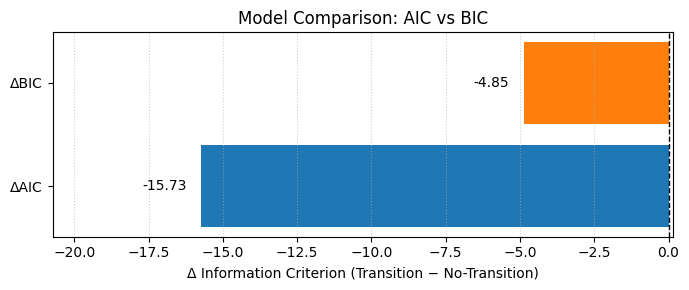

In [10]:
import matplotlib.pyplot as plt

# Define model comparison values
delta_aic = aic_transition - aic_no_transition
delta_bic = bic_transition - bic_no_transition

# Values and labels
metrics = ["ΔAIC", "ΔBIC"]
values = [delta_aic, delta_bic]
colors = ["#1f77b4", "#ff7f0e"]  # Blue for AIC, Orange for BIC

# Plot
fig, ax = plt.subplots(figsize=(7, 3))

bars = ax.barh(metrics, values, color=colors)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5*np.sign(width), bar.get_y() + bar.get_height()/2,
            f"{width:.2f}", va='center', ha='left' if width > 0 else 'right')

# Labels and formatting
ax.set_xlabel("Δ Information Criterion (Transition − No-Transition)")
ax.set_title("Model Comparison: AIC vs BIC")
ax.set_xlim(min(values) - 5, max(values) + 5)
plt.tight_layout()
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.savefig("delta_AIC_BIC_comparison.png", dpi=300)
plt.show()


In [47]:
# --- Our Python best-fit values and uncertainties (transition model) ---
Mlow_best = M_low_best
Mhigh_best = M_high_best
Omega_m_best = Omega_m_best  # already named consistently
h_best = H0_best / 100.0
d_crit_best = d_crit_best  # already named from result.x
chi2_min_transition=chi2_min_transition

# Inferred from inverse Fisher matrix
errors_transition = errors_5D

# --- Our Python best-fit values and uncertainties (no-transition model) ---
chi2_min_notransition = chi2_min_notransition
M_best_notransition = M_best_notransition
Omega_m_best_notransition = Omega_m_best_notransition
h_best_notransition = h_best_notransition
errors_notransition = errors

# --- P&S results ---
ps_transition = {
    "Chi2_min": "1503.38",
    "M_<": "-19.392 ± 0.0454869",
    "M_>": "-19.205 ± 0.0386",
    "Omega_m": "0.332 ± 0.0179822",
    "h": "0.7481 ± 0.0107871",
    "d_crit": "19.944 ± 0.0944496"
}

ps_notransition = {
    "Chi2_min": "1522.98",
    "M": "-19.248 ± 0.029437",
    "Omega_m": "0.333 ± 0.017993",
    "h": "0.7342 ± 0.0101021",
    "d_crit": "---"
}

# --- Our Python results formatted ---
py_transition = {
    "Chi2_min": f"{chi2_min_transition:.2f}",
    "M_<": f"{Mlow_best:.3f} ± {errors_transition[0]:.4f}",
    "M_>": f"{Mhigh_best:.3f} ± {errors_transition[1]:.4f}",
    "Omega_m": f"{Omega_m_best:.5f} ± {errors_transition[2]:.4f}",
    "h": f"{h_best:.5f} ± {errors_transition[3]:.4f}",
    "d_crit": f"{d_crit_best:.5f} ± {errors_transition[4]:.4f}"
}

py_notransition = {
    "Chi2_min": f"{chi2_min_notransition:.2f}",
    "M": f"{M_best_notransition:.3f} ± {errors_notransition[0]:.4f}",
    "Omega_m": f"{Omega_m_best_notransition:.5f} ± {errors_notransition[1]:.4f}",
    "h": f"{h_best_notransition:.5f} ± {errors_notransition[2]:.4f}",
    "d_crit": "---"
}

# --- Build DataFrame ---
results_table = pd.DataFrame({
    "Python (no-transition)": py_notransition,
    "P&S (no-transition)": ps_notransition,
    "Python (transition)": py_transition,
    "P&S (transition)": ps_transition
})

# --- Display styled table ---
styled_table = results_table.style.set_table_styles([
    {'selector': 'th', 'props': [('border', '2px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]}
]).set_properties(**{
    'text-align': 'center'
}).set_caption("Comparison of Inferred Cosmological Parameters (Python vs. P&S)")

display(styled_table)


,Python (no-transition),P&S (no-transition),Python (transition),P&S (transition)
Chi2_min,1522.98,1522.98,1503.25,1503.38
M,-19.248 ± 0.0294,-19.248 ± 0.029437,nan,nan
Omega_m,0.33280 ± 0.0180,0.333 ± 0.017993,0.33204 ± 0.0180,0.332 ± 0.0179822
h,0.73420 ± 0.0101,0.7342 ± 0.0101021,0.74805 ± 0.0108,0.7481 ± 0.0107871
d_crit,---,---,19.94358 ± 0.0944,19.944 ± 0.0944496
M_<,nan,nan,-19.399 ± 0.0466,-19.392 ± 0.0454869
M_>,nan,nan,-19.207 ± 0.0309,-19.205 ± 0.0386


# Contour Plots

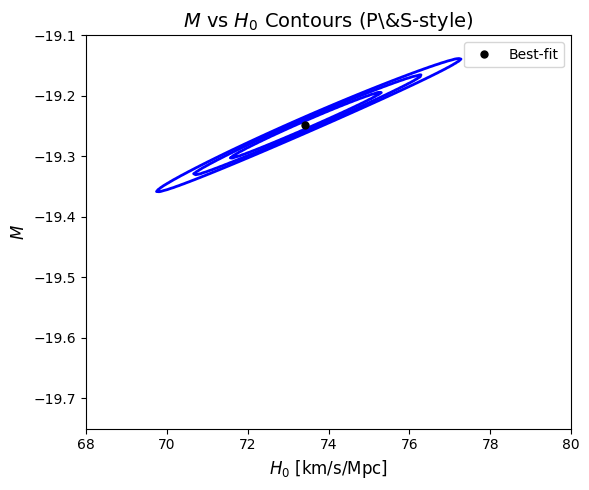

⏱️ Execution time: 205.91 seconds


In [12]:
start_time = time.time()

# --- Cosmology + Distance ---
@lru_cache(maxsize=None)
def integral_dL(z, H0, Omega_m):
    integrand = lambda zp: 1 / np.sqrt(Omega_m * (1 + zp)**3 + (1 - Omega_m))
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

def mu_theory(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL(float(z), float(H0), float(Omega_m))) + 25
        for z in z_array
    ])

# --- Chi2 for no-transition model ---
def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, Omega_m = params
    mu_model = mu_theory(z, H0, Omega_m)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        mB - M - mu_model
    )
    return Q.T @ C_inv @ Q

# --- Gamma-based Δχ² thresholds (dof = 3) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 3) for n in [1, 2, 3]]

# --- Grid setup for M vs H0 ---
M_range = np.linspace(-19.75, -19.10, 200)
H0_range = np.linspace(68, 80, 200)

# --- Load best-fit values from no-transition minimization ---
M_best = M_best_notransition
H0_best = H0_best_notransition
Omega_m_best = Omega_m_best_notransition

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_notransition([M, H0, Omega_m_best], z, mB, mu_Ceph, is_calibrator, C_inv)
        for H0 in H0_range
    ]
    for M in M_range
])

# --- Save data ---
os.makedirs("contour_data", exist_ok=True)
np.savez("contour_data/contour_data_M_H0.npz",
         M=M_range, H0=H0_range, chi2=chi2_grid,
         M_best=M_best, H0_best=H0_best)

# --- Plotting ---
chi2_min = chi2_notransition([M_best, H0_best, Omega_m_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(H0_range, M_range, dchi2, levels=levels, colors='blue', linewidths=2)
plt.plot(H0_best, M_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.title(r"$M$ vs $H_0$ Contours (P\&S-style)", fontsize=14)

# (NO σ LABELS)
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("M_vs_H0_PandS_style.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


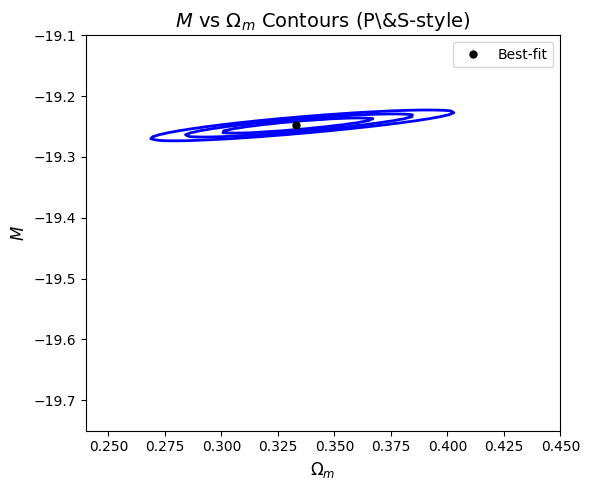

In [13]:
# --- Grid setup for M vs Omega ---
M_range = np.linspace(-19.75, -19.10, 200)
Om_range = np.linspace(0.24, 0.45, 200)

# --- Best-fit values (from no-transition minimization) ---
M_best = M_best_notransition
H0_best = H0_best_notransition
Omega_m_best = Omega_m_best_notransition

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_notransition([M, H0_best, Om], z, mB, mu_Ceph, is_calibrator, C_inv)
        for Om in Om_range
    ]
    for M in M_range
])

# --- Save output ---
os.makedirs("contour_data", exist_ok=True)
np.savez("contour_data/contour_data_M_Om.npz",
         M=M_range, Om=Om_range, chi2=chi2_grid,
         M_best=M_best, Om_best=Omega_m_best)

# --- Plotting ---
chi2_min = chi2_notransition([M_best, H0_best, Omega_m_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(Om_range, M_range, dchi2, levels=levels, colors='blue', linewidths=2)
plt.plot(Omega_m_best, M_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.title(r"$M$ vs $\Omega_m$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("M_vs_Om_PandS_style.pdf", dpi=300)
plt.show()

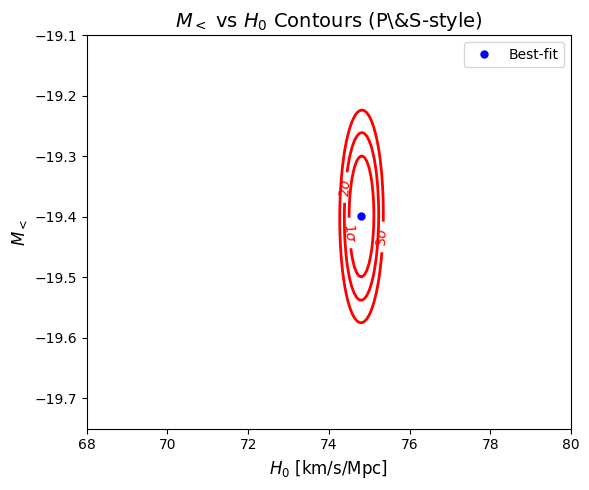

⏱️ Execution time: 397.26 seconds


In [8]:
start_time=time.time()

# --- Cosmological chi-square function with transition ---
@lru_cache(maxsize=None)
def integral_dL(z, H0, Omega_m):
    integrand = lambda zp: 1 / np.sqrt(Omega_m * (1 + zp)**3 + (1 - Omega_m))
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

def mu_theory(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL(float(z), float(H0), float(Omega_m))) + 25
        for z in z_array
    ])

def chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, mu_SH0ES=19.253):
    M_low, M_high, H0, Omega_m, mu_crit = params
    Q = []
    for i in range(len(z)):
        mu_model = mu_theory([z[i]], H0, Omega_m)[0]
        mu_i_S = mB[i] + mu_SH0ES
        if is_calibrator[i] == 1:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_Ceph[i]
        else:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_model
        Q.append(Q_i)
    Q = np.array(Q)
    return Q @ C_inv @ Q

# --- Define Gamma-based contour thresholds (P&S-style) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]  # 5 parameters

# --- Grid setup ---
Mlow_range = np.linspace(-19.75, -19.10, 200)
H0_range = np.linspace(68, 80, 200)

# --- Load best-fit values (from previous minimization) ---
M_low_best, M_high_best, H0_best, Omega_m_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition(
            [M_low, M_high_best, H0, Omega_m_best, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for H0 in H0_range
    ]
    for M_low in Mlow_range
])

# --- Save grid ---
os.makedirs("contour_data", exist_ok=True)
np.savez("contour_data/contour_data_Mlow_H0.npz",
         Mlow=Mlow_range, H0=H0_range, chi2=chi2_grid,
         M_low_best=M_low_best, H0_best=H0_best)

# --- Plot ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(H0_range, Mlow_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(H0_best, M_low_best, 'bo', label='Best-fit', markersize=5)

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M_<$", fontsize=12)
plt.title(r"$M_<$ vs $H_0$ Contours (P\&S-style)", fontsize=14)

# Annotate contours
fmt = {level: rf"${n}\sigma$" for n, level in zip([1, 2, 3], levels)}
plt.clabel(CS, inline=True, fmt=fmt, fontsize=10)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mlow_vs_H0_PandS_style.pdf", dpi=300)
plt.show()


end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

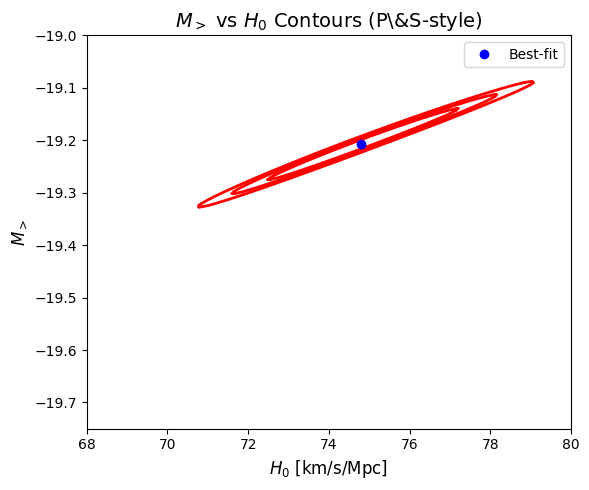

⏱️ Execution time: 389.86 seconds


In [9]:
start_time=time.time()

# --- Define Gamma-based Delta Chi2 (P&S style) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]  # 5 parameters total

# --- Cosmological distance and chi2 definitions ---
@lru_cache(maxsize=None)
def integral_dL(z, H0, Omega_m):
    integrand = lambda zp: 1 / np.sqrt(Omega_m * (1 + zp)**3 + (1 - Omega_m))
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

def mu_theory(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL(float(z), float(H0), float(Omega_m))) + 25
        for z in z_array
    ])

def chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, mu_SH0ES=19.253):
    M_low, M_high, H0, Omega_m, mu_crit = params
    Q = []
    for i in range(len(z)):
        mu_model = mu_theory([z[i]], H0, Omega_m)[0]
        mu_i_S = mB[i] + mu_SH0ES
        if is_calibrator[i] == 1:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_Ceph[i]
        else:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_model
        Q.append(Q_i)
    Q = np.array(Q)
    return Q @ C_inv @ Q

# --- Grid setup ---
Mhigh_range = np.linspace(-19.75, -19.00, 200)
H0_range = np.linspace(68, 80, 200)

# --- Use best-fit parameters (you already have these from minimization) ---
M_low_best, M_high_best, H0_best, Omega_m_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25

# --- Clean existing file if needed ---
os.makedirs("contour_data", exist_ok=True)
try:
    os.remove("contour_data/contour_data_Mhigh_H0.npz")
except FileNotFoundError:
    pass

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition(
            [M_low_best, M_high, H0, Omega_m_best, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for H0 in H0_range
    ]
    for M_high in Mhigh_range
])

# --- Save new grid ---
np.savez("contour_data/contour_data_Mhigh_H0.npz",
         Mhigh=Mhigh_range, H0=H0_range, chi2=chi2_grid,
         M_high_best=M_high_best, H0_best=H0_best)

# --- Plot ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
plt.contour(H0_range, Mhigh_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(H0_best, M_high_best, 'bo', markersize=6, label='Best-fit')

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M_>$", fontsize=12)
plt.title(r"$M_>$ vs $H_0$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mhigh_vs_H0_PandS_style.pdf", dpi=300)
plt.show()


end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

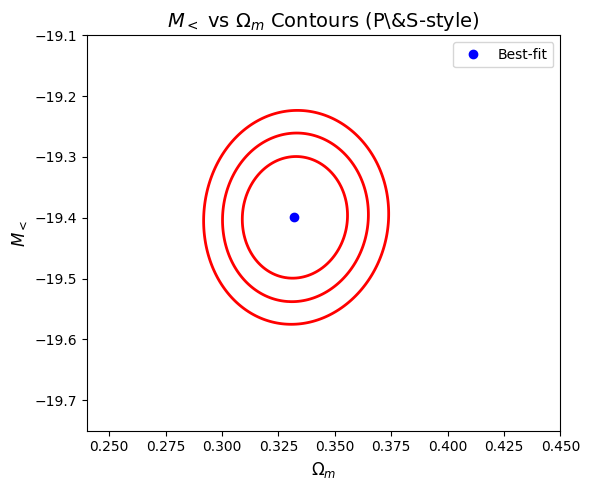

⏱️ Execution time: 512.28 seconds


In [10]:
start_time=time.time()

def chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, mu_SH0ES=19.253):
    M_low, M_high, H0, Omega_m, mu_crit = params
    Q = []
    for i in range(len(z)):
        mu_model = mu_theory([z[i]], H0, Omega_m)[0]
        mu_i_S = mB[i] + mu_SH0ES
        if is_calibrator[i] == 1:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_Ceph[i]
        else:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_model
        Q.append(Q_i)
    Q = np.array(Q)
    return Q @ C_inv @ Q

# --- Grid setup for M< vs Omega ---
Mlow_range = np.linspace(-19.75, -19.10, 200)
Om_range = np.linspace(0.24, 0.45, 200)

# --- Best-fit values from transition minimization ---
M_low_best, M_high_best, H0_best, Omega_m_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25


# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition(
            [M_low, M_high_best, H0_best, Om, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for Om in Om_range
    ]
    for M_low in Mlow_range
])

# --- Save grid ---
np.savez("contour_data/contour_data_Mlow_Om.npz",
         Mlow=Mlow_range, Om=Om_range, chi2=chi2_grid,
         M_low_best=M_low_best, Om_best=Omega_m_best)

# --- Plotting ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
plt.contour(Om_range, Mlow_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(Omega_m_best, M_low_best, 'bo', markersize=6, label='Best-fit')

plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M_<$", fontsize=12)
plt.title(r"$M_<$ vs $\Omega_m$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mlow_vs_Om_PandS_style.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

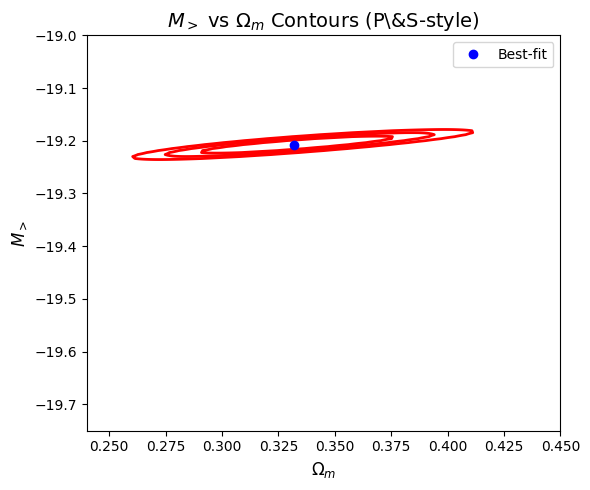

⏱️ Execution time: 387.27 seconds


In [11]:
start_time = time.time()

# --- Grid setup ---
Mhigh_range = np.linspace(-19.75, -19.00, 200)
Om_range = np.linspace(0.24, 0.45, 200)

# --- Best-fit values from previous minimization ---
M_low_best, M_high_best, H0_best, Omega_m_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition(
            [M_low_best, M_high, H0_best, Om, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for Om in Om_range
    ]
    for M_high in Mhigh_range
])

# --- Save result ---
np.savez("contour_data/contour_data_Mhigh_Om.npz",
         Mhigh=Mhigh_range, Om=Om_range, chi2=chi2_grid,
         M_high_best=M_high_best, Om_best=Omega_m_best)

# --- Plotting ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
plt.contour(Om_range, Mhigh_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(Omega_m_best, M_high_best, 'bo', markersize=6, label='Best-fit')

plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M_>$", fontsize=12)
plt.title(r"$M_>$ vs $\Omega_m$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mhigh_vs_Om_PandS_style.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


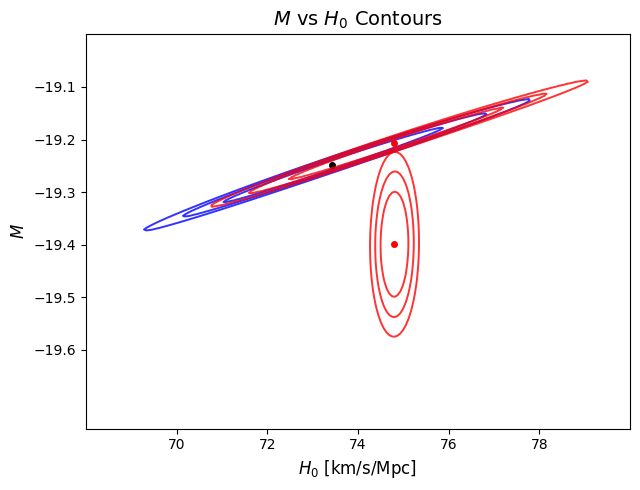

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load raw chi2 data from .npz files ---
data_M_H0 = np.load("contour_data/contour_data_M_H0.npz")
data_Mlow_H0 = np.load("contour_data/contour_data_Mlow_H0.npz")
data_Mhigh_H0 = np.load("contour_data/contour_data_Mhigh_H0.npz")

# --- Grids ---
H0_range = data_M_H0["H0"]
M_range = data_M_H0["M"]

Mlow_range = data_Mlow_H0["Mlow"]
Mhigh_range = data_Mhigh_H0["Mhigh"]

# --- Chi2 grids ---
chi2_MH0 = data_M_H0["chi2"]
chi2_Mlow_H0 = data_Mlow_H0["chi2"]
chi2_Mhigh_H0 = data_Mhigh_H0["chi2"]

# --- Convert to Delta Chi2 (subtract true global min for each) ---
dchi2_MH0 = chi2_MH0 - np.min(chi2_MH0)
dchi2_Mlow_H0 = chi2_Mlow_H0 - np.min(chi2_Mlow_H0)
dchi2_Mhigh_H0 = chi2_Mhigh_H0 - np.min(chi2_Mhigh_H0)

# --- Best-fit points ---
H0_best = data_M_H0["H0_best"]
M_best = data_M_H0["M_best"]

H0_best_tr = data_Mlow_H0["H0_best"]
M_low_best = data_Mlow_H0["M_low_best"]
M_high_best = data_Mhigh_H0["M_high_best"]

# --- P&S Gamma-based levels ---
from scipy.special import gamma, gammaincc, gammaincinv, erf

def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gammaincinv(dof / 2, p)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]

plt.figure(figsize=(6.5, 5))


# No-transition (blue)
plt.contour(H0_range, M_range, dchi2_MH0, levels=levels, colors='blue', linewidths=1.4,alpha=0.8)
plt.plot(H0_best, M_best, 'ko', markersize=4)

# Transition M< (red)
plt.contour(H0_range, Mlow_range, dchi2_Mlow_H0, levels=levels, colors='red', linewidths=1.4,alpha=0.8)
plt.plot(H0_best_tr, M_low_best, 'ro', markersize=4)

# Transition M> (red)
plt.contour(H0_range, Mhigh_range, dchi2_Mhigh_H0, levels=levels, colors='red', linewidths=1.4,alpha=0.8)
plt.plot(H0_best_tr, M_high_best, 'ro', markersize=4)

# Axis styling
plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.xlim(H0_range.min(), H0_range.max())
plt.ylim(-19.75, -19.00)
plt.xticks([70, 72, 74, 76, 78])
plt.yticks(np.linspace(-19.6, -19.1, 6))
plt.grid(False)



plt.tight_layout()
plt.savefig("Figure1_H0_side_combined_FIXED_v2.png", dpi=300)
plt.show()



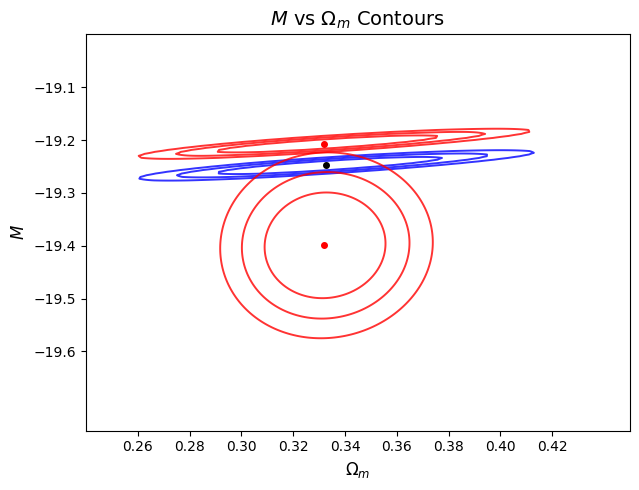

In [33]:
# --- Load raw chi2 data from .npz files ---
data_M_Om = np.load("contour_data/contour_data_M_Om.npz")
data_Mlow_Om = np.load("contour_data/contour_data_Mlow_Om.npz")
data_Mhigh_Om = np.load("contour_data/contour_data_Mhigh_Om.npz")

# --- Grids ---
Om_range = data_M_Om["Om"]
M_range = data_M_Om["M"]

Om_range_low = data_Mlow_Om["Om"]
Mlow_range = data_Mlow_Om["Mlow"]

Om_range_high = data_Mhigh_Om["Om"]
Mhigh_range = data_Mhigh_Om["Mhigh"]

# --- Chi2 grids ---
chi2_MOm = data_M_Om["chi2"]
chi2_Mlow_Om = data_Mlow_Om["chi2"]
chi2_Mhigh_Om = data_Mhigh_Om["chi2"]

# --- Delta chi2 ---
dchi2_MOm = chi2_MOm - np.min(chi2_MOm)
dchi2_Mlow_Om = chi2_Mlow_Om - np.min(chi2_Mlow_Om)
dchi2_Mhigh_Om = chi2_Mhigh_Om - np.min(chi2_Mhigh_Om)

# --- Best-fit points ---
Om_best = data_M_Om["Om_best"]
M_best = data_M_Om["M_best"]

Om_best_tr = data_Mlow_Om["Om_best"]
M_low_best = data_Mlow_Om["M_low_best"]
M_high_best = data_Mhigh_Om["M_high_best"]

# --- P&S Gamma-based levels (already defined) ---
# Using existing `delta_chi2` function and `levels`

# --- Plot ---
plt.figure(figsize=(6.5, 5))

# No-transition (blue)
plt.contour(Om_range, M_range, dchi2_MOm, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
plt.plot(Om_best, M_best, 'ko', markersize=4)

# Transition M< (red)
plt.contour(Om_range_low, Mlow_range, dchi2_Mlow_Om, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
plt.plot(Om_best_tr, M_low_best, 'ro', markersize=4)

# Transition M> (red)
plt.contour(Om_range_high, Mhigh_range, dchi2_Mhigh_Om, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
plt.plot(Om_best_tr, M_high_best, 'ro', markersize=4)

# Axis styling
plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.xlim(Om_range.min(), Om_range.max())
plt.ylim(-19.75, -19.00)
plt.xticks([0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, 0.42])
plt.yticks(np.linspace(-19.6, -19.1, 6))
plt.grid(False)

plt.title(r"$M$ vs $\Omega_m$ Contours", fontsize=14)
plt.tight_layout()
plt.savefig("Figure1_Om_side_combined_FIXED_v2.pdf", dpi=300)
plt.show()


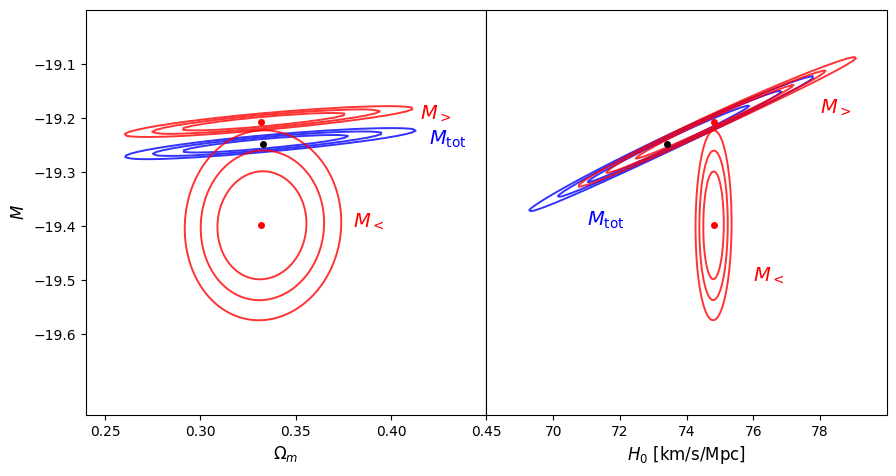

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# --- Load all data ---
data_M_H0 = np.load("contour_data/contour_data_M_H0.npz")
data_M_Om = np.load("contour_data/contour_data_M_Om.npz")
data_Mlow_H0 = np.load("contour_data/contour_data_Mlow_H0.npz")
data_Mhigh_H0 = np.load("contour_data/contour_data_Mhigh_H0.npz")
data_Mlow_Om = np.load("contour_data/contour_data_Mlow_Om.npz")
data_Mhigh_Om = np.load("contour_data/contour_data_Mhigh_Om.npz")

# --- Extract grids and chi2 ---
H0_range = data_M_H0["H0"]
Om_range = data_M_Om["Om"]
M_range = data_M_H0["M"]

Mlow_range_H0 = data_Mlow_H0["Mlow"]
Mhigh_range_H0 = data_Mhigh_H0["Mhigh"]
Mlow_range_Om = data_Mlow_Om["Mlow"]
Mhigh_range_Om = data_Mhigh_Om["Mhigh"]
Om_range_low = data_Mlow_Om["Om"]
Om_range_high = data_Mhigh_Om["Om"]

# --- Extract chi2 grids ---
chi2_MH0 = data_M_H0["chi2"]
chi2_MOm = data_M_Om["chi2"]
chi2_Mlow_H0 = data_Mlow_H0["chi2"]
chi2_Mhigh_H0 = data_Mhigh_H0["chi2"]
chi2_Mlow_Om = data_Mlow_Om["chi2"]
chi2_Mhigh_Om = data_Mhigh_Om["chi2"]

# --- Best-fit values ---
H0_best = data_M_H0["H0_best"]
M_best = data_M_H0["M_best"]
Om_best = data_M_Om["Om_best"]

H0_best_tr = data_Mlow_H0["H0_best"]
Om_best_tr = data_Mlow_Om["Om_best"]
M_low_best = data_Mlow_H0["M_low_best"]
M_high_best = data_Mhigh_H0["M_high_best"]

# --- Delta chi2 normalization ---
dchi2_MH0 = chi2_MH0 - np.min(chi2_MH0)
dchi2_MOm = chi2_MOm - np.min(chi2_MOm)
dchi2_Mlow_H0 = chi2_Mlow_H0 - np.min(chi2_Mlow_H0)
dchi2_Mhigh_H0 = chi2_Mhigh_H0 - np.min(chi2_Mhigh_H0)
dchi2_Mlow_Om = chi2_Mlow_Om - np.min(chi2_Mlow_Om)
dchi2_Mhigh_Om = chi2_Mhigh_Om - np.min(chi2_Mhigh_Om)

# --- Confidence levels (Gamma-based) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gammaincinv(dof / 2, p)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]

# --- Plot ---
fig = plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
gs.update(wspace=0.0)

# --- LEFT: M vs Omega ---
ax1 = plt.subplot(gs[0])
ax1.contour(Om_range, M_range, dchi2_MOm, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
ax1.contour(Om_range_low, Mlow_range_Om, dchi2_Mlow_Om, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax1.contour(Om_range_high, Mhigh_range_Om, dchi2_Mhigh_Om, levels=levels, colors='red', linewidths=1.4, alpha=0.8)

ax1.plot(Om_best, M_best, 'ko', markersize=4)
ax1.plot(Om_best_tr, M_low_best, 'ro', markersize=4)
ax1.plot(Om_best_tr, M_high_best, 'ro', markersize=4)
ax1.text(0.38, -19.40, r"$M_{<}$", color='red', fontsize=14)
ax1.text(0.415, -19.20, r"$M_{>}$", color='red', fontsize=14)
ax1.text(0.42, -19.25, r"$M_{\mathrm{tot}}$", color='blue', fontsize=14)
ax1.set_xlabel(r"$\Omega_m$", fontsize=12)
ax1.set_ylabel(r"$M$", fontsize=12)
ax1.set_xlim(Om_range.min(), Om_range.max())
ax1.set_ylim(-19.75, -19.00)
ax1.set_xticks([0.25, 0.30, 0.35, 0.40, 0.45])
ax1.set_yticks(np.linspace(-19.6, -19.1, 6))
ax1.tick_params(axis='both', labelsize=10)

# --- RIGHT: M vs H0 ---
ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.contour(H0_range, M_range, dchi2_MH0, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
ax2.contour(H0_range, Mlow_range_H0, dchi2_Mlow_H0, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax2.contour(H0_range, Mhigh_range_H0, dchi2_Mhigh_H0, levels=levels, colors='red', linewidths=1.4, alpha=0.8)

ax2.plot(H0_best, M_best, 'ko', markersize=4)
ax2.plot(H0_best_tr, M_low_best, 'ro', markersize=4)
ax2.plot(H0_best_tr, M_high_best, 'ro', markersize=4)
ax2.text(78, -19.19, r"$M_{>}$", color='red', fontsize=14)
ax2.text(76, -19.50, r"$M_{<}$", color='red', fontsize=14)
ax2.text(71.0, -19.40, r"$M_{\mathrm{tot}}$", color='blue', fontsize=14)
ax2.set_xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
ax2.set_xlim(H0_range.min(), H0_range.max())
ax2.set_xticks([70, 72, 74, 76, 78])
ax2.tick_params(axis='y', labelleft=False, left=False)


# --- Save ---
plt.subplots_adjust(left=0.08, right=0.97, bottom=0.12, top=0.93)
plt.savefig("Figure1.png", dpi=300)
plt.show()
